# Image Classification Using AWS SageMaker

This notebook uses a pre-trained Resnet50 model from PyTorch to classify dog breeds.  The dog breeds dataset contains 133 breeds of dogs and hyperparameter tuning is used to fine tune the CNN model.  The model is then deployed to an endpoint and sample predictions are made.

In [3]:
# Uncomment to install the sdmebug package
#!pip install smdebug

## Import SageMaker Python SDK and other libraries

In [4]:
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role

Initialize SageMaker variables.

In [5]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

Region us-east-1
Default s3 bucket : sagemaker-us-east-1-914704477742


## Dataset
We will be using a dataset of dog breeds provided by Udacity.  This dataset contains images from 133 dog breeds divided into training, testing, and validation datasets.

In [6]:
# Uncomment the command below to fetch and upload the data to AWS S3

# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

#### Upload data to S3

In [7]:
prefix ="dogImages_data"
print('Uploading dogImages data...')

# uncomment below to upload data
# inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

# save inputs as a string to avoid uploading data twice
inputs = 's3://sagemaker-us-east-1-914704477742/dogImages_data'
print(f'dogImages data uploaded to S3 file path: {inputs}')

Uploading dogImages data...
dogImages data uploaded to S3 file path: s3://sagemaker-us-east-1-914704477742/dogImages_data


#### Verify data has been uploaded to S3

In [8]:
! aws s3 ls  s3://sagemaker-us-east-1-914704477742/dogImages_data/

                           PRE test/
                           PRE train/
                           PRE valid/


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
# Declare hyperparameter ranges, metrics etc.

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

# Initialize the hyperparameters ranges
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([64, 128]),
    "epochs": IntegerParameter(2, 4)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

#### Creae the estimator
We will be using an `ml.g4dn.xlarge` as our instance type which uses a GPU and allows for accelerated computing with a fast launch.  This estimator will make use of the `hpo.py` python script.

In [10]:
# Create estimators for the hyperparameters
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo.py", # hyperparameter optimization script
    base_job_name = "dogImages-classifier-hpo",
    role = role,
    py_version = "py36",
    framework_version = "1.8",
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge", # GPU for accelerated computing w/fast launch
    max_run=600 # train for 10 minutes
)

# Create the HyperparameterTuner Object
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

Select training, test, and validation datasets and fit them to the tuner.

In [11]:
model_inputs = {"train": f"s3://{bucket}/dogImages_data/train/",
                "test":f"s3://{bucket}/dogImages_data/test/",
                "validate": f"s3://{bucket}/dogImages_data/valid/"}
model_inputs

{'train': 's3://sagemaker-us-east-1-914704477742/dogImages_data/train/',
 'test': 's3://sagemaker-us-east-1-914704477742/dogImages_data/test/',
 'validate': 's3://sagemaker-us-east-1-914704477742/dogImages_data/valid/'}

In [17]:
# Fit the hyperparameter Tuner
# 'training' key comes from 'training' in parser.add_argument('--data_dir', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
tuner.fit(model_inputs, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................................................................................................................................!


In [18]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

print(f'Base Job Name: {estimator.base_job_name}')
#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-12-24 07:01:38 Starting - Preparing the instances for training
2022-12-24 07:01:38 Downloading - Downloading input data
2022-12-24 07:01:38 Training - Training image download completed. Training in progress.
2022-12-24 07:01:38 Uploading - Uploading generated training model
2022-12-24 07:01:38 Completed - Resource reused by training job: pytorch-training-221224-0651-003-868dd325
Base Job Name: dogImages-classifier-hpo


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'epochs': '2',
 'lr': '0.001029469210957',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dogImages-classifier-hpo-2022-12-24-06-51-13-299"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-914704477742/dogImages-classifier-hpo-2022-12-24-06-51-13-299/source/sourcedir.tar.gz"'}

Let's review the best hyperparameters found from our training.

In [19]:
# need to replace "" in batch_size or else value will be returned as a string and not an integer
best_hyperparameters = {'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                   "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": best_estimator.hyperparameters()['epochs']}

best_hyperparameters

{'batch_size': 128, 'lr': '0.001029469210957', 'epochs': '2'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [20]:
# Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)


hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

Setup the CollectionConfig and HookConfig objects.

https://sagemaker.readthedocs.io/en/stable/api/training/debugger.html#sagemaker.debugger.CollectionConfig

In [21]:
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig(collection_configs=collection_configs )

In [26]:
# Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.8",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit(model_inputs,wait=True)

2022-12-24 07:44:32 Starting - Starting the training job...
2022-12-24 07:45:02 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-12-24 07:46:03 Downloading - Downloading input data......
2022-12-24 07:47:02 Training - Downloading the training image............
2022-12-24 07:49:04 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-24 07:49:14,242 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-24 07:49:14,267 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-24 07:49:14,270 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-24 07:49:14,543 sagemaker-training-toolkit INFO     

In [27]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2022-12-24-07-44-32-461
Region: us-east-1


#### Check Training Performance

In [28]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-12-24 07:57:11.577 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19659 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-24 07:57:11.590 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19659 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-914704477742/pytorch-training-2022-12-24-07-44-32-461/debug-output
[2022-12-24 07:57:12.917 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19659 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-12-24 07:57:13.936 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19659 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'lay

In [29]:
# get tensor names from trial
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

#### Setup functions to log and plot the output tensors

In [30]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [31]:
# Plot a debugging output.

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


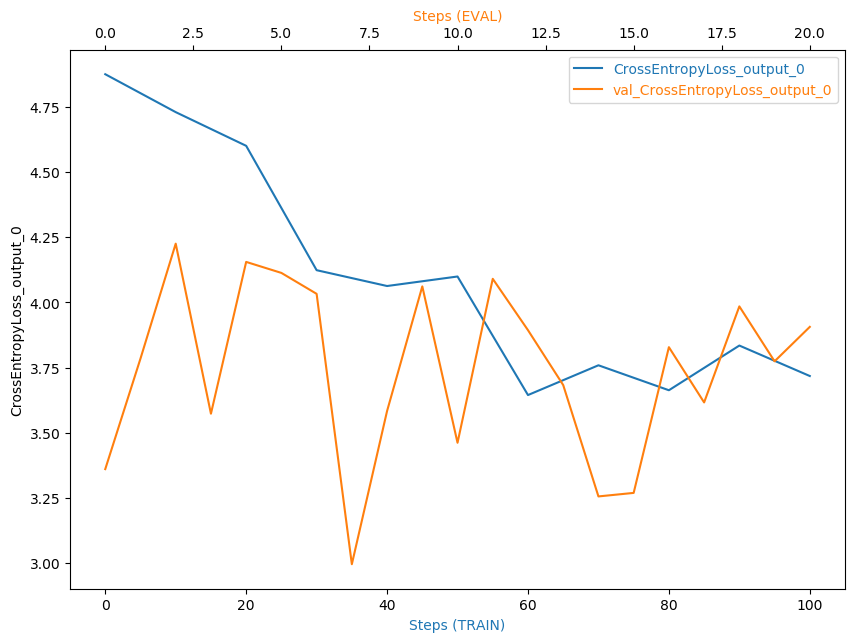

In [32]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?**
- From the output above we can see that there isn't any anomalous behavior.

**If not, suppose there was an error. What would that error look like and how would you have fixed it?**
- If anomalous behavior were present then some optiosn to improve performance would be to try a different architecture for the CNN model along with using a wider range of hyperparameters.


In [33]:
# Display the profiler output

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-914704477742/pytorch-training-2022-12-24-07-44-32-461/rule-output


In [34]:
! aws s3 ls {rule_output_path} --recursive

2022-12-24 07:55:34     416015 pytorch-training-2022-12-24-07-44-32-461/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-12-24 07:55:33     270620 pytorch-training-2022-12-24-07-44-32-461/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-12-24 07:55:29        192 pytorch-training-2022-12-24-07-44-32-461/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-12-24 07:55:29      19275 pytorch-training-2022-12-24-07-44-32-461/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-12-24 07:55:29       2115 pytorch-training-2022-12-24-07-44-32-461/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-12-24 07:55:29        326 pytorch-training-2022-12-24-07-44-32-461/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-12-24 07:55:29       3339 pytorch-training-2022-12-24-07-44-32-461/rule-output/ProfilerReport/profiler-output/profiler-re

In [35]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-914704477742/pytorch-training-2022-12-24-07-44-32-461/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-914704477742/pytorch-training-2022-12-24-07-44-32-461/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-914704477742/pytorch-training-2022-12-24-07-44-32-461/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-914704477742/pytorch-training-2022-12-24-07-44-32-461/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-914704477742/pytorc

In [36]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


In [51]:
import IPython

# IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying
Start by getting the path of the model produced from the estimator.

In [38]:
# get the location of our model
model_path = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_path}")

Model: s3://sagemaker-us-east-1-914704477742/pytorch-training-2022-12-24-07-44-32-461/output/model.tar.gz


We will create a PyTorch model using the architecture from the estimator that was used for training.

In [39]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        
pytorch_model = PyTorchModel(model_data=model_path,
                             role=role,
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

#### Deploy the predictor

In [40]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

--------------!

#### Run predictions on the endpoint
Dog Breed:  Maltese

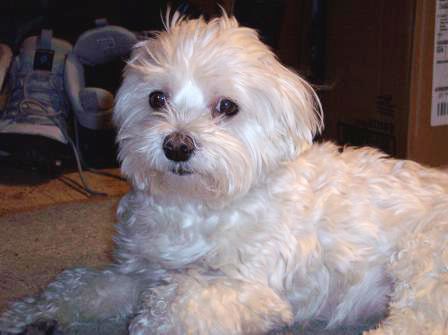

Response: [[-1.1923322677612305, -4.266831398010254, -2.893047571182251, -3.486236572265625, -5.573883533477783, -2.9423153400421143, -1.8134229183197021, -2.8168747425079346, -1.5527632236480713, -2.5008902549743652, -4.079634189605713, -3.5719377994537354, -4.083134174346924, -3.18546986579895, -2.3403565883636475, -3.1638710498809814, -1.2473819255828857, -3.1734371185302734, -2.4037725925445557, -4.690258026123047, -4.712186813354492, -3.106966257095337, -2.504509449005127, -2.802090644836426, -2.827592134475708, -3.922333002090454, -1.9575437307357788, -0.6024250984191895, -6.955360412597656, -1.0007996559143066, -0.6506037712097168, -2.1314358711242676, -3.0176291465759277, -3.653757095336914, -2.5361666679382324, -1.1908354759216309, -2.4136133193969727, -0.05126211792230606, -3.7850501537323, -5.316003322601318, -3.2743489742279053, -2.638228178024292, -4.487752914428711, -4.807624816894531, -1.6821236610412598, -1.8133103847503662, -3.4140446186065674, -2.087021827697754, -2.8

In [48]:
from sagemaker.serializers import IdentitySerializer
import base64
from PIL import Image
import io
import numpy as np

with open("./dogImages/test/101.Maltese/Maltese_06716.jpg", "rb") as f:
    payload = f.read()
    display(Image.open(io.BytesIO(payload)))
    response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response}\n")
    print('Maltese dog breed category is 101')
    predicted_category = np.argmax(response,1) + 1
    print(f'Predicted category is {predicted_category}')

Dog Breed:  Poodle

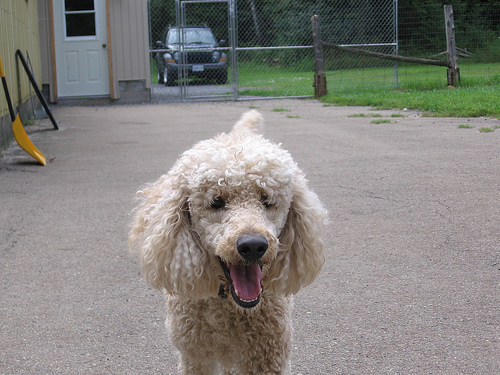

Response: [[-3.4269051551818848, -3.2713966369628906, -2.2552688121795654, -0.7734638452529907, -1.9171656370162964, -2.2818493843078613, -1.8173214197158813, -1.3962807655334473, -0.5405173301696777, -0.01910138875246048, -2.0103394985198975, -4.067050933837891, -3.4031667709350586, -1.433933138847351, -1.8446329832077026, -2.6803536415100098, -3.1601834297180176, -2.2805962562561035, -2.017469882965088, -1.8495285511016846, -2.428219795227051, -2.7295799255371094, -1.7608845233917236, -2.5427019596099854, -2.3573951721191406, -3.6723642349243164, -1.1586973667144775, -1.7375155687332153, -5.594822883605957, -1.213584542274475, -1.1271668672561646, -1.4744452238082886, -1.456093430519104, -3.2210097312927246, -3.08467435836792, -1.233298897743225, -1.971985936164856, -1.0602048635482788, -3.6756021976470947, -3.7708933353424072, -2.990161657333374, -1.496106505393982, -3.548915147781372, -3.3955130577087402, -1.4301234483718872, -2.1343650817871094, -2.9558157920837402, -1.77190077304

In [42]:
with open("./dogImages/test/124.Poodle/Poodle_07925.jpg", "rb") as f:
    payload = f.read()
    display(Image.open(io.BytesIO(payload)))
    response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response}\n")
    print('Poodle dog breed category is 124')
    predicted_category = np.argmax(response,1) + 1
    print(f'Predicted category is {predicted_category}')

#### Delete endpoint

In [50]:
predictor.delete_endpoint()